# Recognizing Misinformation
This is the group project for CS 4641 Machine Learning


In [ ]:
# Authenticate Google Drive access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/CS\ 4641\ Group\ Project/Data

/content/drive/My Drive/CS 4641 Group Project/Data


In [ ]:
!pip install cmudict
!pip install tldextract

     |████████████████████████████████| 942kB 5.8MB/s 
     |████████████████████████████████| 92kB 3.8MB/s 


In [ ]:
import tldextract
import urllib.request
import nltk
import sys
import cmudict
import string
import re
import matplotlib
import statistics 
import graphviz 
import pydot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree as tree

from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

from collections import Counter
from textblob import TextBlob
from yellowbrick.cluster import SilhouetteVisualizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, words
from nltk.tag import pos_tag

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Import and Clean Data

In [ ]:
url = 'https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv'
urllib.request.urlretrieve(url,"corona_fake.csv")
df = pd.read_csv('corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

#change all nan strings to empty string
df = df.fillna('')

print(df.tail())

In [ ]:
sources = list()
true_false = list()
all_sources = list()

for i in range(len(df.index)):
  if str(df.loc[i]["label"]).lower() == "true":
    true_false.append("true")
  else:
    true_false.append("fake")

  source = str(df.loc[i]["source"]).lower()
  all_sources.append(source)
  domain = str(tldextract.extract(source).domain).lower()
  suffix = str(tldextract.extract(source).suffix).lower()
  if source == "facebook" or domain == "facebook" or source == "twitter" or domain == "twitter" or source == "youtube" or domain == "youtube":
    sources.append("facebook/twitter/youtube")
  elif source == "cdc" or domain == "cdc" or source == "who" or domain == "who":
    sources.append("medical")
  elif suffix == "edu" or source == "harvard" or domain == "harvard":
    sources.append("education")
  elif source == "europa" or domain == "europa" or suffix == "ca" or suffix == "ru":
    sources.append("government")
  elif source == "nytimes" or domain == "nytimes" or source == "cnn" or domain == "cnn" or source == "washingtonpost" or domain == "washingtonpost" or source == "usatoday" or domain == "usatoday" or source == "reuters" or domain == "reuters" or source == "archive" or domain == "archive" or source == "bbc" or domain == "bbc" or source == "rt" or domain == "rt":
    sources.append("news")
  else:
    sources.append("others")

df = df.drop(columns=['source', 'label'])
df['source'] = sources 
df['label'] = true_false 

print(str(len(true_false)) + " analyzed")

# Feature Engineering

## Tf-idf

In [ ]:
#tf-idf

test = df.copy().fillna('')


vectorizer = TfidfVectorizer(stop_words='english', min_df=.2)
#sparse tfidf
tfidf_vectors = vectorizer.fit_transform(test['text'])
#column names
terms = vectorizer.get_feature_names()
tfidf_terms = []
for term in terms:
  tfidf_terms.append('tfidf_' + term)

tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_vectors, columns=tfidf_terms)

#tfidf_df.loc[tfidf_df['tfidf_virus']!=0, ['tfidf_virus']]
print(test.dtypes)
print(tfidf_df.dtypes)

#add to dataframe
tfidf_big = pd.concat((test,tfidf_df), axis=1)

title     object
text      object
source    object
label     object
dtype: object
tfidf_19           Sparse[float64, 0]
tfidf_according    Sparse[float64, 0]
tfidf_based        Sparse[float64, 0]
tfidf_called       Sparse[float64, 0]
tfidf_care         Sparse[float64, 0]
                          ...        
tfidf_work         Sparse[float64, 0]
tfidf_world        Sparse[float64, 0]
tfidf_wuhan        Sparse[float64, 0]
tfidf_year         Sparse[float64, 0]
tfidf_years        Sparse[float64, 0]
Length: 76, dtype: object


### References
Dataset : [towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7](https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7)

## Stylistic Analysis


In [ ]:
def count_stopwords(text):
  #takes in string and returns the number of stopwords in itprint("counting stopwords..")
  STOPWORDS = set(stopwords.words('english'))
  word_vec = text.split()
  count=0
  for word in word_vec:
    if word in STOPWORDS:
      count +=1
  count /= (len(text)+1)
  return count

def count_pn(text): #potential problem: includes random words starting with a capital letter
  word_vec = text.split()
  tagged_sent = pos_tag(word_vec)
  propernouns = [word for word,pos in tagged_sent if ((pos == 'NNP') or (pos == 'NNPS'))]
  #print(propernouns)
  count_pn = len(propernouns)
  count_pn /= (len(text)+1)
  return count_pn

def count_adj(text):
  word_vec = text.split()
  tagged_sent = pos_tag(word_vec)
  adj = [word for word,pos in tagged_sent if ((pos == 'JJ') or (pos == 'JJR') or (pos == 'JJS'))]
  count_adj= len(adj)
  count_adj /= (len(text)+1)
  return count_adj

def count_negation(text): 
  word_vec = text.split()
  negation_words = ["no", "not", "none", "nobody", "nothing", "neither", "nowhere", "never", "dont", "don't", "shouldnt", "shouldn't"]
  count=0
  for word in word_vec:
    if word in negation_words:
      count +=1
  count /= (len(text)+1)
  return count

  #capital letter frequency
def capital_letter_freq(text):
    if not pd.isna(text):
        caps = sum(1 for c in text if c.isupper())
        length = max(1, len(text))
        return caps/length
    else:
        return 0

df['stopwords'] = df.apply(lambda row: count_stopwords(row.text), axis=1)
df['propernouns'] = df.apply(lambda row: count_pn(row.text), axis=1)
df['adjectives'] = df.apply(lambda row: count_adj(row.text), axis=1)
df['negation'] = df.apply(lambda row: count_negation(row.text), axis=1)
df['capital_letter_freq'] = df.apply(lambda row: capital_letter_freq(row.text), axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
nltk.download('punkt')

def TTR(text):
  if len(text) == 0:
    return 0
  text = re.sub(r'[^\w]', ' ', text)
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  types = nltk.Counter(tokens)

  return (len(types)/len(tokens))

def FKG_readability(text):
  # 0.39 * (wrd_ct / sent_ct) + 11.8 * (tot_syll / wrd_ct) - 15.59
  if len(text) == 0:
    return 0
  d = cmudict.dict()
  tot_syll = 0 
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  stripped_words = [w.translate(table) for w in words]
  for w in stripped_words:
    num_syll = max([len([y for y in x if y[-1].isdigit()]) for x in d[w.lower()]], default=None)
    num_syll = 1 if num_syll == None else num_syll
  # print("tot_syll " + str(tot_syll))

  wrd_ct = len(words)
  # print("wrd_ct " + str(wrd_ct))

  pattern  = re.compile(r'([^\.!?]*[\.!?])', re.M)
  sent_ct = len(pattern.findall(text))
  # print("sent_ct " + str(sent_ct))
  if sent_ct == 0:
    sent_ct = 1

  return (0.39 * (wrd_ct / sent_ct)) + (11.8 * (tot_syll / wrd_ct)) - 15.59
   

def GFG_readability(text):
 # 0.4 [(words/sentences) + 100 (words with > 3 syllables /words)]
  if len(text) == 0:
    return 0
  d = cmudict.dict()
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  stripped_words = [w.translate(table) for w in words]

  cplx_ct = 0 
  for w in stripped_words:
    num_syll = max([len([y for y in x if y[-1].isdigit()]) for x in d[w.lower()]], default=None)
    num_syll = 1 if num_syll == None else num_syll
    cplx_ct += 1 if num_syll > 3 else 0
  # print("cplx_ct " + str(cplx_ct))

  wrd_ct = len(words)
  # print("wrd_ct " + str(wrd_ct))

  pattern  = re.compile(r'([^\.!?]*[\.!?])', re.M)
  sent_ct = len(pattern.findall(text))
  if sent_ct == 0:
    sent_ct = 1
  # print("sent_ct " + str(sent_ct))

  return 0.4 * ((wrd_ct / sent_ct) + (100 * (cplx_ct / wrd_ct)))

def word_length(text):
  if len(text) == 0:
    return 0
  words = text.split()
  return sum(len(word) for word in words) / len(words)

def num_quotes(text):
  if len(text) == 0:
    return 0
  return ((len(text.split('"')) - 1)/2) / len(text)

  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("Running TTR...")
df['TTR'] = df.apply(lambda row: TTR(row.text), axis=1)
#print("Running FKG...")
#df['FKG_readability'] = df.apply(lambda row: FKG_readability(row.text), axis=1)
#print("Running GFG...")
#df['GFG_readability'] = df.apply(lambda row: GFG_readability(row.text), axis=1)
print("Running word_length...")
df['word_length'] = df.apply(lambda row: word_length(row.text), axis=1)
print("Running num_quotes...")
df['num_quotes'] = df.apply(lambda row: word_length(row.text), axis=1)

## Sentiment Analysis

In [ ]:
df['polarity'] = df.apply(lambda row: TextBlob(row.title + ' ' + row.text).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda row: TextBlob(row.title + ' ' + row.text).sentiment.subjectivity, axis=1)

## Misspelling

In [ ]:
nltk.download('stopwords')
nltk.download('words')

In [ ]:
# Combine sentences into one list, remove trailing spaces, remove symbols and make everything lower case 

sentences = list()

for i in range(len(df.index)):
  title = ""
  text = ""
  if df.loc[i]["title"]:
    title = str(df.loc[i]["title"])
  if df.loc[i]["text"]:
    text = str(df.loc[i]["text"])

  title = title.strip()
  title = re.sub('[^\w\d\s]', '', title)
  title = title.lower()

  text = text.strip()
  text = re.sub('[^\w\d\s]', '', text)
  text = text.lower()

  sentences.append((title.split(), text.split()))

print("number of sentences: " + str(len(sentences)))

In [ ]:
# Stop words we need to remove from the paragraph

stop_words = stopwords.words('english')
stop_words[:] = [re.sub('[^\w\d\s]', '', word) for word in stop_words]
stop_words[:] = [word.lower() for word in stop_words]

print("number of stop words: " + str(len(stop_words)))
print(stop_words)

In [ ]:
# Remove stop words

count_new = 0
count = 0

new_sentences = list()

for sentence in sentences:
  new_title_words = list()
  for j in range(len(sentence[0])):
    word = sentence[0][j]
    if word not in stop_words:
      new_title_words.append(word)
      count_new += 1
    count += 1

  new_text_words = list()
  for j in range(len(sentence[1])):
    word = sentence[1][j]
    if word not in stop_words:
      new_text_words.append(word)
      count_new += 1
    count += 1

  new_sentences.append([new_title_words, new_text_words])
  
  sys.stdout.write("\rwords analyzed: " + str(count))
  sys.stdout.flush()

sentences = new_sentences
print("\ntotal words remaining: " + str(count_new))

In [ ]:
# Count misspelling

count_new = 0
count = 0
title_misspellings_list = list()
text_misspellings_list = list()

english_words = set(words.words())

english_words.add("covid19")
english_words.add("coronavirus")
english_words.add("covid")

lower_set = set()
for word in english_words:
  lower_set.add(word.lower())
english_words = lower_set

new_sentences = list()

for sentence in sentences:
  new_title_words = list()
  count_not_misspelling = 0
  for j in range(len(sentence[0])):
    word = sentence[0][j]
    if word in english_words:
      new_title_words.append(word)
      count_not_misspelling += 1
      count_new += 1
    count += 1
  
  if len(sentence[0]) == 0:
    title_misspellings_list.append(0.0)
  else:
    title_misspellings_list.append((len(sentence[0]) - count_not_misspelling) / len(sentence[0]))

  new_text_words = list()
  count_not_misspelling = 0
  for j in range(len(sentence[1])):
    word = sentence[1][j]
    if word in english_words:
      new_text_words.append(word)
      count_not_misspelling += 1
      count_new += 1
    count += 1


  if len(sentence[1]) == 0:
    text_misspellings_list.append(0.0)
  else:
    text_misspellings_list.append((len(sentence[1]) - count_not_misspelling) / (len(sentence[1])))

  new_sentences.append([new_title_words, new_text_words])
  
  sys.stdout.write("\rwords analyzed: " + str(count))
  sys.stdout.flush()

sentences = new_sentences
print("\ntotal words remaining: " + str(count_new))

In [ ]:
df['title_misspelling_count'] = title_misspellings_list 
df['text_misspelling_count'] = text_misspellings_list 

In [ ]:
df

# Export

In [ ]:
df

In [ ]:
df.to_pickle("dataframe")

a = pd.concat((df,tfidf_df), axis=1)
a.to_pickle("ogdata_features_tfidf")
tfidf_df.to_pickle("just_tfidf")
b = df.drop('title',axis=1)
b = b.drop('text', axis=1)
b = b.drop('source', axis=1)
b = b.drop('label', axis=1)

b.to_pickle("just_features_no_tfidf")
b = pd.concat((b,tfidf_df), axis=1)
b.to_pickle("just_features_and_tfidf")


#df.to_pickle("with_tfidf")

In [ ]:
just_features_tfidf = pd.read_pickle("just_features_and_tfidf")

# Clustering

## Normalized

In [ ]:
temp = df.drop(columns=['title', 'text', 'source', 'label'])
x = temp.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)

In [ ]:
print(normalized.columns)
normalized.to_pickle("normalized")

In [ ]:
source_loc = df.columns.get_loc("source")
label_loc = df.columns.get_loc("label")
np_df = df.to_numpy()
df_notext = df.drop(columns=['title', 'text', 'source', 'label'])
print("source " + str(source_loc))
print("label " + str(label_loc))

## PCA

## DBScan

<class 'numpy.ndarray'>


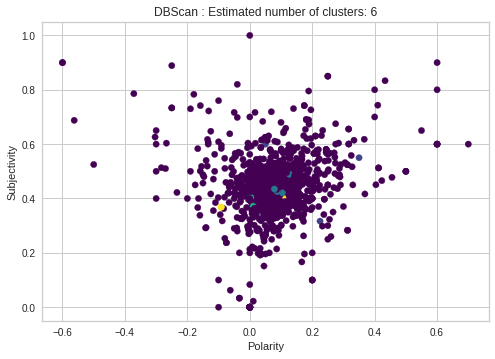

In [ ]:
X = just_features_tfidf.to_numpy()
print(type(X))
db = DBSCAN().fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

plt.scatter(X[:, df.columns.get_loc("polarity") - 4], X[:, df.columns.get_loc("subjectivity") - 4], c=labels, s=40, cmap='viridis');
plt.title('DBScan : Estimated number of clusters: %d' % len(set(labels)))
plt.xlabel("Polarity") 
plt.ylabel("Subjectivity") 
plt.show()

## GMM

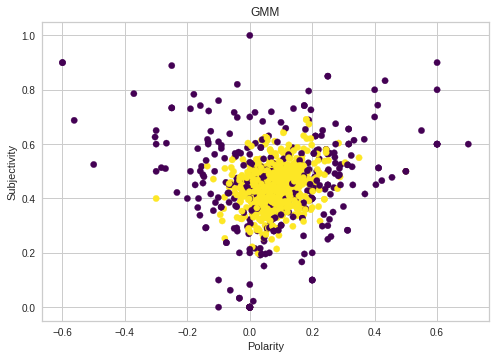

In [ ]:
X = just_features_tfidf.to_numpy()
gmm = GaussianMixture(n_components=2).fit(normalized)
labels = gmm.predict(normalized)
plt.scatter(X[:, df.columns.get_loc("polarity") - 4], X[:, df.columns.get_loc("subjectivity") - 4], c=labels, s=40, cmap='viridis');
plt.title('GMM')
plt.xlabel("Polarity") 
plt.ylabel("Subjectivity") 
plt.show()

## K-Means

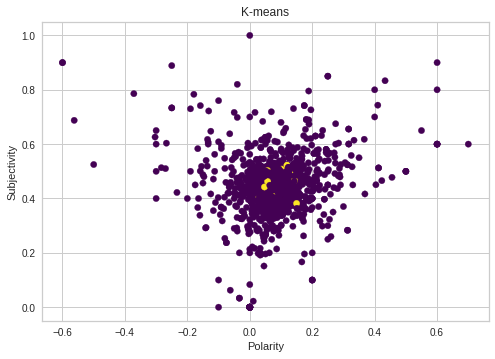

In [ ]:
X = just_features_tfidf.to_numpy()
kmeans = KMeans(n_clusters=2).fit(X)
labels = kmeans.predict(X)
plt.scatter(X[:, df.columns.get_loc("polarity") - 4], X[:, df.columns.get_loc("subjectivity") - 4], c=labels, s=40, cmap="viridis");
plt.title('K-means')
plt.xlabel("Polarity") 
plt.ylabel("Subjectivity") 
plt.show()

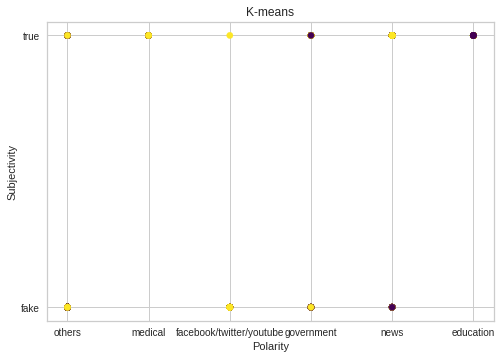

In [ ]:
X = normalized.to_numpy()
kmeans = KMeans(n_clusters=2).fit(X)
labels = kmeans.predict(X)
plt.scatter(df.to_numpy()[:, df.columns.get_loc("source")], df.to_numpy()[:, df.columns.get_loc("label")], c=labels, s=40, cmap="viridis");
plt.title('K-means')
plt.xlabel("Polarity") 
plt.ylabel("Subjectivity") 
plt.show()

0.8289738430583501
0.6558891454965358
0.015345268542199489


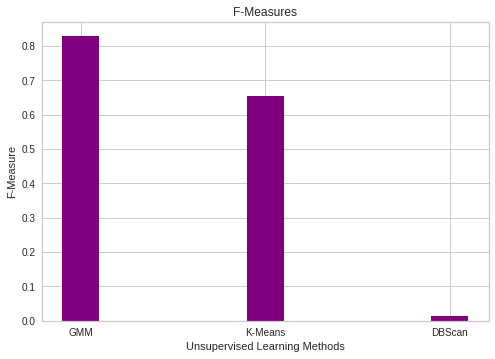

In [ ]:
actual_labels = df['label'].tolist()

for idx in range(len(actual_labels)):
  actual_labels[idx] =  0 if actual_labels[idx] == 'FALSE' else 1

f_gmm = f1_score(actual_labels, df['gmm'].tolist(), average='weighted')
f_kmeans = f1_score(actual_labels, df['kmeans'].tolist(), average='weighted')
f_dbscan = f1_score(actual_labels, df['dbscan'].tolist(), average='weighted')

print(f_gmm)
print(f_kmeans)
print(f_dbscan)

algos = ['GMM', 'K-Means', "DBScan"]
f_measures = [f_gmm, f_kmeans, f_dbscan]
plt.bar(algos, f_measures, color ='purple',  width = 0.2) 
plt.xlabel("Unsupervised Learning Methods") 
plt.ylabel("F-Measure") 
plt.title("F-Measures") 
plt.show()

# Visualizations

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f05c9602908>,
                     model=None)

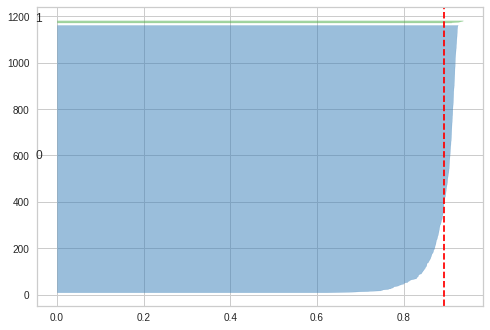

In [ ]:
X = df_notext.to_numpy()

kmeans = KMeans(n_clusters=2).fit(X)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(X)

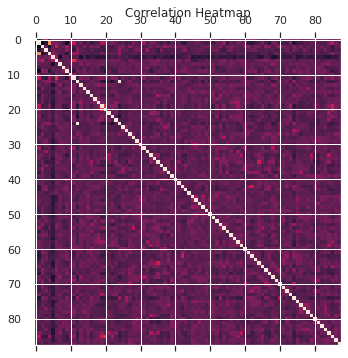

In [ ]:
plt.matshow(just_features_tfidf.corr())
plt.title("Correlation Heatmap")
plt.show()

# Feature Selection

Correlated features: capital letter frequency and number of proper nouns.

We drop proper nouns because it is less correlated with the label.

                         stopwords  ...  text_misspelling_count
stopwords                 1.000000  ...               -0.097566
propernouns              -0.309603  ...                0.305822
adjectives                0.012355  ...               -0.078034
negation                  0.284848  ...               -0.132529
capital_letter_freq      -0.258305  ...                0.184528
TTR                       0.052736  ...               -0.028378
word_length              -0.026631  ...                0.431262
num_quotes                0.022924  ...                0.028712
polarity                  0.075229  ...               -0.019595
subjectivity              0.204663  ...               -0.143413
title_misspelling_count  -0.073228  ...                0.198821
text_misspelling_count   -0.097566  ...                1.000000

[12 rows x 12 columns]


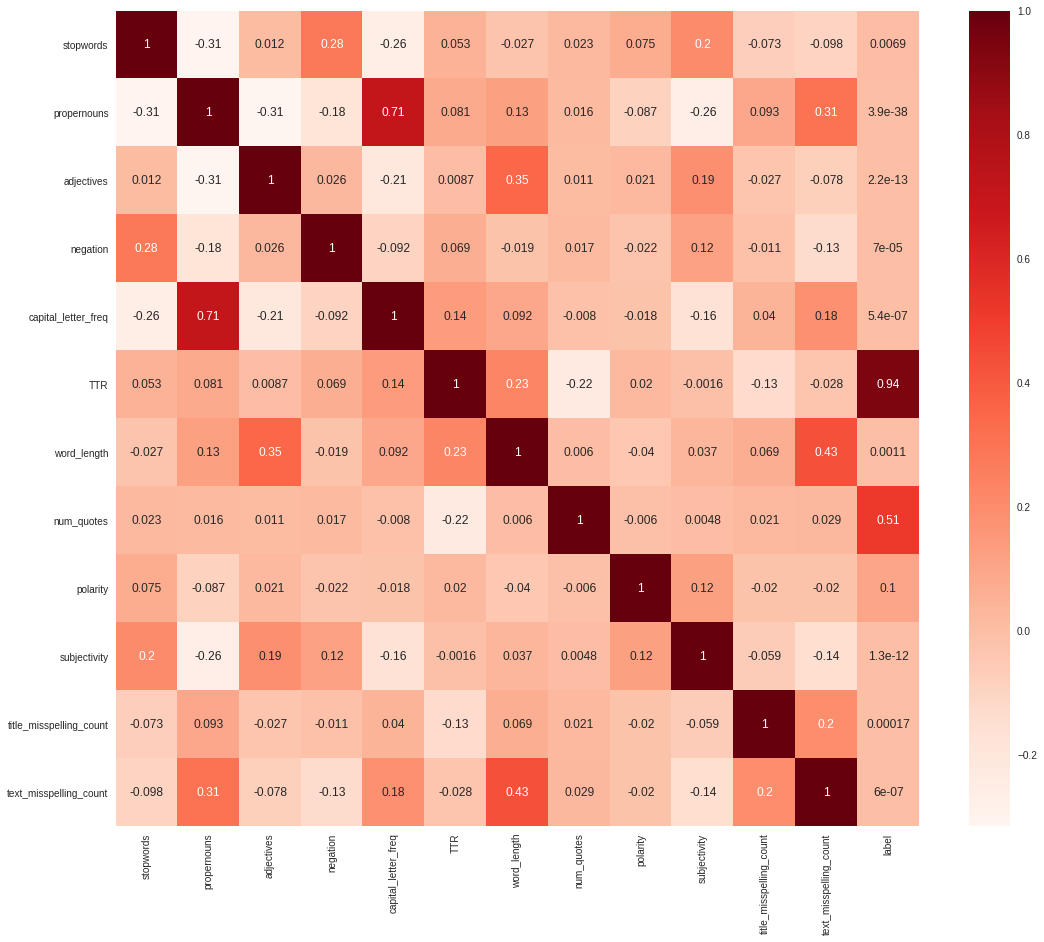

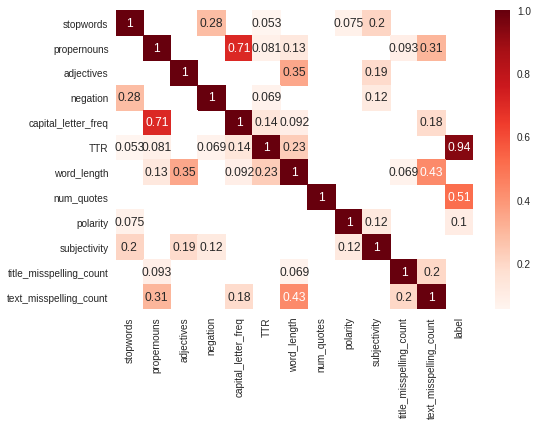

In [ ]:
from scipy import stats

data = pd.read_pickle("dataframe")
data['label'] = data['label'].map({'true':1 ,'fake':0}) 
y = data['label']

data = pd.read_pickle("just_features_no_tfidf")
# data['label'] = y
label_cor = []
for col in data:
  column = data[col]
  label_cor.append(stats.pointbiserialr(y, column)[1])

plt.figure(figsize=(18,15))
cor = data.corr()
print((cor))

cor['label'] = label_cor

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# features with correlation > 0.5
relevant_features = cor[cor>0.05]
relevant_features
sns.heatmap(relevant_features, annot=True, cmap=plt.cm.Reds)
plt.show()

[5.442663637575764e-18, 0.06496819804210556, 0.014786923471986825, 0.07971476613564064, 1.547014465955583e-11, 0.7987119477025569, 0.00470947047631597, 1.4632973472205054e-26, 4.660261980185278e-21, 2.4693967042180368e-05, 1.376070760089876e-20, 0.7739983259283495, 1.3678567123440208e-17, 0.014814584235295948, 0.033341083382498325, 1.3126182729297757e-06, 0.7615777526094751, 0.8271465053068587, 0.007983888061647546, 0.0004425355517289782, 0.0008830972887158441, 9.533001213733414e-10, 4.3138636156037146e-12, 2.6841090721790353e-05, 4.99510090969682e-06, 0.06044873908038916, 3.573124988812689e-09, 0.004149960010591228, 0.005642347636736589, 0.3558057062625323, 2.6666367612583634e-11, 0.0004223603469061814, 0.9428029018015982, 8.546387087447366e-11, 0.34672210590097685, 0.7066971157033446, 0.2682441934616377, 0.02192482869129192, 0.33085284583896635, 0.01665636736602995, 1.5918598303611994e-16, 0.010000896959854703, 0.0894193413632046, 0.0007341901793048282, 0.40335676902897255, 0.9214934

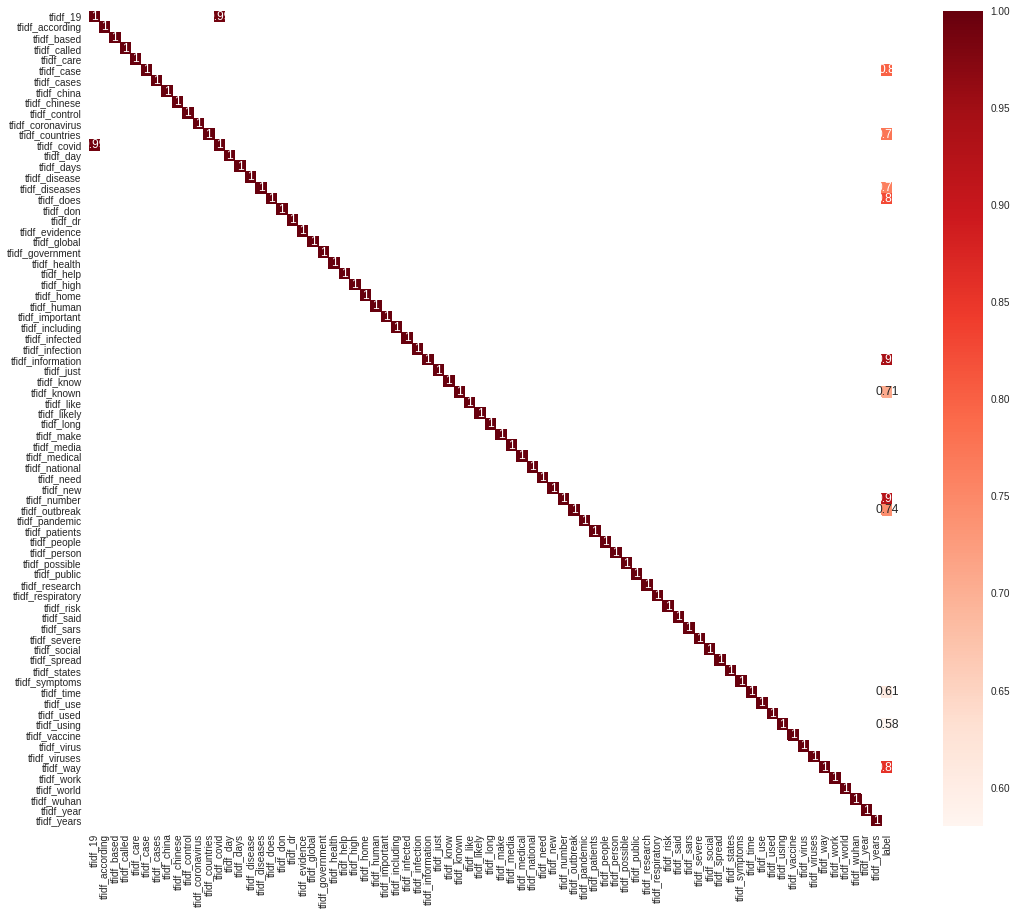

In [ ]:
from scipy import stats

data = pd.read_pickle("dataframe")
data['label'] = data['label'].map({'true':1 ,'fake':0}) 
y = data['label']

data = pd.read_pickle("just_tfidf")
# data['label'] = y
label_cor = []
for col in data:
  column = data[col]
  label_cor.append(stats.pointbiserialr(y, column)[1])

plt.figure(figsize=(18,15))
cor = data.corr()
print(label_cor)
print((cor))

cor['label'] = label_cor

# sns.heatmap(cor, cmap=plt.cm.Reds)
# plt.show()

# features with correlation > 0.5
# cor = data.corr()
relevant_features = cor[cor>0.5]
relevant_features

sns.heatmap(relevant_features, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:


# plt.figure(figsize=(18,15))
# cor = data.corr()
# sns.heatmap(cor, cmap=plt.cm.Reds)
# plt.show()

# cor




Index(['title', 'text', 'source', 'label', 'stopwords', 'propernouns',
       'adjectives', 'negation', 'capital_letter_freq', 'TTR', 'word_length',
       'num_quotes', 'polarity', 'subjectivity', 'title_misspelling_count',
       'text_misspelling_count'],
      dtype='object')
0       0
1       0
2       0
3       0
4       0
       ..
1159    1
1160    1
1161    1
1162    1
1163    1
Name: label, Length: 1164, dtype: int64
[0.0069297261094966285, 3.939929495086259e-38, 2.2435208567304882e-13, 6.979489828525367e-05, 5.447115682657224e-07, 0.9400050410872386, 0.001052466799482343, 0.5149278253762978, 0.10255117341313809, 1.3000447481664686e-12, 0.00016768858994760177, 5.953172008704305e-07]


# Supervised Learning


In [ ]:
df = pd.read_csv('corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df.fillna('')

labels = df['label'].tolist()

In [ ]:
features_and_tfidf = pd.read_pickle("just_features_and_tfidf")

X = features_and_tfidf.to_numpy()
y = np.array(labels)
feature_names = list(features_and_tfidf.columns.values)

print(features_and_tfidf.shape)

(1164, 88)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Decision Tree

In [ ]:
accuracy = []
for depth in range(1, 75):
  depth_accuracy = []
  for num in range(10):
    decision = DecisionTreeClassifier(max_depth=depth)
    model = decision.fit(X_train, y_train)
    prediction = model.predict(X_test)
    depth_accuracy.append(accuracy_score(y_test, prediction))
  accuracy.append(statistics.mean(depth_accuracy))

print("optimal depth " + str(accuracy.index(max(accuracy)) + 1))
print("optimal depth accuracy " + str(max(accuracy)))

optimal depth 9
optimal depth accuracy 0.8324675324675325


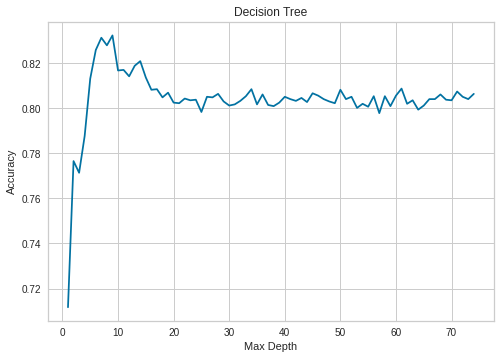

In [ ]:
plt.plot(np.arange(1, len(accuracy) + 1), accuracy)
plt.title("Decision Tree")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.show()

In [ ]:
decision = DecisionTreeClassifier(max_depth=9)
model = decision.fit(X_train, y_train)

data = tree.export_graphviz(model, out_file="decisiontree.dot", filled=True, rounded=True, special_characters=True, feature_names=feature_names)  

(graph,) = pydot.graph_from_dot_file('decisiontree.dot')
graph.write_png('decisiontree.png')

## Random Forest

## Multi-Level Perceptron

In [ ]:
just_features_tfidf = pd.read_pickle("just_features_and_tfidf")
X = just_features_tfidf.to_numpy()
df = pd.read_pickle("dataframe")
actual_labels = df['label'].tolist()
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, actual_labels)
pred_labels = clf.predict(X)
print(classification_report(actual_labels, pred_labels))

              precision    recall  f1-score   support

        fake       0.59      0.10      0.17       578
        true       0.51      0.93      0.66       586

    accuracy                           0.52      1164
   macro avg       0.55      0.52      0.41      1164
weighted avg       0.55      0.52      0.42      1164



## SVM

              precision    recall  f1-score   support

        fake       0.83      0.79      0.81       188
        true       0.81      0.85      0.83       197

    accuracy                           0.82       385
   macro avg       0.82      0.82      0.82       385
weighted avg       0.82      0.82      0.82       385



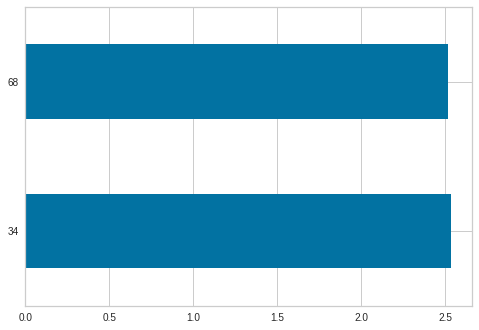

In [ ]:
from sklearn import svm

just_features_tfidf = pd.read_pickle("just_features_and_tfidf")
X = just_features_tfidf.to_numpy()
df = pd.read_pickle("dataframe")
y = df['label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
pd.Series(abs(clf.coef_[0]), index=np.arange(len(clf.coef_[0]))).nlargest(2).plot(kind='barh')
pred_labels = clf.predict(X_test)
print(classification_report(y_test, pred_labels))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


hello ['0' '0' '0' ... '1' '1' '1']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


hello ['0' '0' '0' ... '1' '1' '1']
hello ['0' '0' '0' ... '1' '1' '1']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


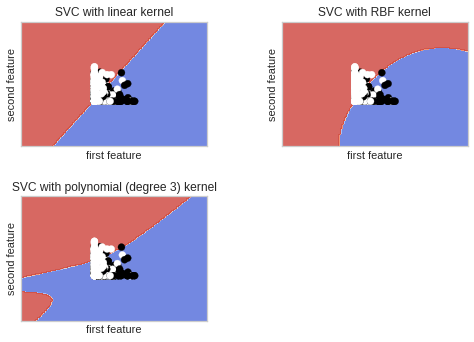

In [ ]:
#SVM visualization
from sklearn import svm, datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


just_features_tfidf = pd.read_pickle("just_features_and_tfidf")
X = just_features_tfidf.to_numpy()[:, [34,68]]
df = pd.read_pickle("dataframe")
y = df['label'].tolist()
y = np.where(y=='true', 1, y)
y = np.where(y=='fake', 0, y)

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)

rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    Z[Z=='true'] = 1
    Z[Z=='fake'] = 0
    xx[xx=='true'] = 1
    xx[xx=='fake'] = 0
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Plot also the training points
    y = np.where(y=='true', 1, y)
    y = np.where(y=='fake', 0, y)
    print("hello", y)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('first feature')
    plt.ylabel('second feature')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()